In [1]:
import os
import pickle
import numpy as np
from model_learning.examples.reward_model_multiagent_inference import OUTPUT_DIR

print(OUTPUT_DIR)
NUM_TRAJECTORIES = 16
TRAJ_LENGTH = 25
MODEL_RATIONALITY = 10
FOLDER_NAME = f'team_trajs_md_{NUM_TRAJECTORIES}x{TRAJ_LENGTH}_{MODEL_RATIONALITY}'
TRAJ_DIR = os.path.join(OUTPUT_DIR, FOLDER_NAME)
print(TRAJ_DIR)
if not os.path.exists(TRAJ_DIR):
    os.mkdir(TRAJ_DIR)
LOAD = 0
SPLIT = 0


/Users/haochen/Desktop/IRL/model-learning/model_learning/examples/output/examples/reward-model-multiagent
/Users/haochen/Desktop/IRL/model-learning/model_learning/examples/output/examples/reward-model-multiagent/team_trajs_md_16x25_10


In [2]:
if LOAD: # load collected traj history data file
    f = open(os.path.join(OUTPUT_DIR, f'{FOLDER_NAME}.pkl'), 'rb')
    team_trajs = pickle.load(f)
    f.close()
    print(team_trajs)
else:
    team_trajs = []


In [3]:
if LOAD and SPLIT:
    for t_i, t in enumerate(team_trajs):
        f = open(os.path.join(TRAJ_DIR, f'ti_{t_i}.pkl'), 'wb')
        pickle.dump(t, f)
        f.close()

In [4]:
from model_learning.examples.reward_model_multiagent_inference import _get_fancy_name, _get_belief
from model_learning.util.plot import plot_evolution

TEAM_AGENTS = ['Goal', 'Navigator']
MODEL_ROLES = ['Self', 'Uniform']  # TODO, 'Random']
team_models = {f'{agent_name}_{role_name}': 0 for role_name in MODEL_ROLES for agent_name in TEAM_AGENTS}
MODEL_NAMES = list(team_models.keys())

def get_team_model_evolution_data(team_trajs, show_info=False):
    model_evolve = []
    for traj_i, team_traj in enumerate(team_trajs):
        model_evolve_per_traj = []
        for step_i, tsam in enumerate(team_traj):
            if step_i > -1:
                _world = tsam.world
                _team = [_world.agents[agent_name] for agent_name in TEAM_AGENTS]
                if show_info:
                    print('==================')
                    print('Step', step_i)
                    [print(tsam.action[agent_name]) for agent_name in TEAM_AGENTS]
                    print(tsam.model_dist)
                observer = _world.agents['observer']

                model_dist = Distribution(team_models)
                for ag_i, agent in enumerate(_team):
                    if ag_i in {0, 1}:
                        agent_model = modelKey(agent.name)
                        agent_dist = _get_belief(_world, agent_model, observer)
                        if show_info:
                            print(f'Belief about Agent {agent.name} model:\n{agent_dist}')
                            possible_models = list(agent_dist.keys())
                            for pm in possible_models:
                                print(agent.models[pm]['name'])
                                a = _world.getFeature(modelKey(_team[1-ag_i].name), state=agent.models[pm]['beliefs'])
                                print(a)
                        for agent_model, model_prob in agent_dist.items():
                            agent_model_name = agent_model.rstrip(string.digits)
                            model_dist[agent_model_name] += model_prob
                model_evolve_per_traj.append(list(model_dist.values()))
        model_evolve.append(model_evolve_per_traj)
    return np.array(model_evolve)

def get_agent_evolve_from(team_evolve, model_name):
    assert type(team_evolve) == np.ndarray
    assert model_name in MODEL_NAMES
    return team_evolve[:, :, MODEL_NAMES.index(model_name)]

if LOAD:
    team_probs = get_team_model_evolution_data(team_trajs)
    np.savez(os.path.join(TRAJ_DIR, f'team_trajs.npz'), team_probs=team_probs)

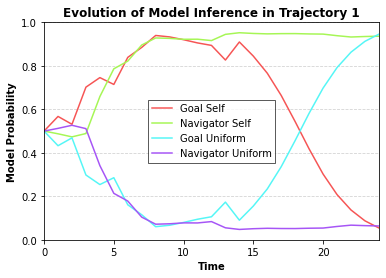

In [5]:
# import matplotlib.pyplot as plt
%matplotlib inline

team_probs = np.load(os.path.join(TRAJ_DIR, f'team_trajs.npz'))['team_probs']
traj_i = 0
plot_evolution(team_probs[traj_i].T, [_get_fancy_name(name) for name in MODEL_NAMES],
               f'Evolution of Model Inference in Trajectory {traj_i+1}', None,
               os.path.join(TRAJ_DIR, f'inference_{traj_i}.png'), 'Time', 'Model Probability', True, [0,1])

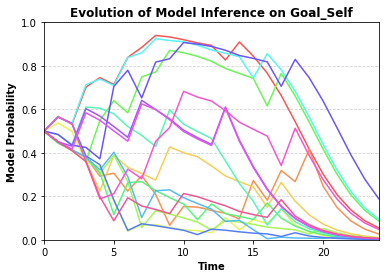

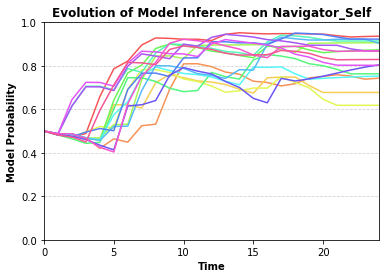

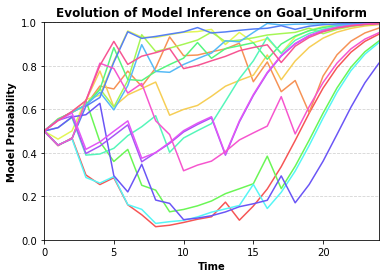

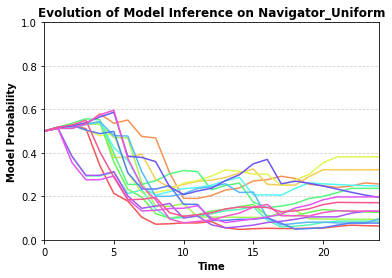

In [6]:
for model_name in MODEL_NAMES:
    agent_probs = get_agent_evolve_from(team_probs, model_name)
    plot_evolution(agent_probs, [_get_fancy_name(model_name) for i in range(len(agent_probs))],
               f'Evolution of Model Inference on {model_name}', None,
               os.path.join(TRAJ_DIR, f'inference_{model_name}.png'), 'Time', 'Model Probability', True, [0,1])